🚀 Starting inference...
🚀 Starting batch inference...
✅ Found checkpoint: ./out/checkpoints/IMAGENET_4_13.0_0.08_AWGN_19h20m35s_on_Jul_15_2025/epoch_499.pth
Loading model with inner channel c=4
Output image saved to reconstructed_output.png


/tmp/ipykernel_3870687/4118217650.py:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=device))


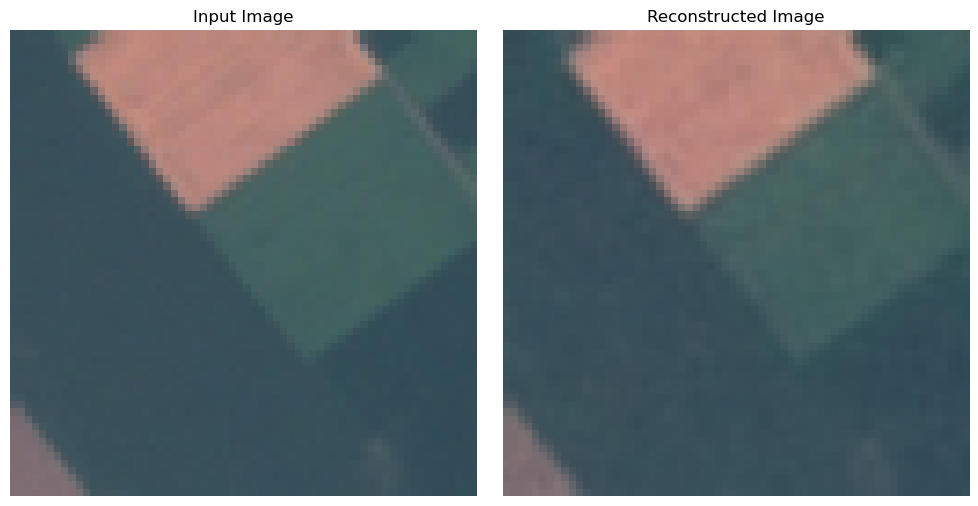

In [27]:
# -*- coding: utf-8 -*-
"""
Inference Script for DeepJSCC
"""
import os
import glob
import torch
from PIL import Image
from torchvision import transforms

from model import DeepJSCC, ratio2filtersize
from utils import image_normalization
import matplotlib.pyplot as plt
# ---------- CONFIGURATION ----------

IMAGE_PATH = '/home/MATLAB_DATA/TiNguyen/Sentry_Data/test/AnnualCrop/AnnualCrop_2111.jpg'  # Path to image for testing
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# These must match your training config
DATASET = 'imagenet'
SNR = 13.0
RATIO = 1 / 12
CHANNEL_TYPE = 'AWGN'
IMAGE_SIZE = (64, 64)  # Size used during training (e.g. 64x64 for ImageNet)

def auto_find_checkpoint(dataset, c, snr, ratio, channel, base_dir='./out/checkpoints'):
    prefix = f"{dataset.upper()}_{c}_{snr}_{ratio:.2f}_{channel}_"
    candidates = [
        os.path.join(base_dir, d)
        for d in os.listdir(base_dir)
        if os.path.isdir(os.path.join(base_dir, d)) and d.startswith(prefix)
    ]
    if not candidates:
        raise FileNotFoundError(f"No checkpoint directories found with prefix: {prefix}")
    latest_dir = max(candidates, key=os.path.getmtime)
    ckpts = glob.glob(os.path.join(latest_dir, 'epoch_*.pth'))
    if not ckpts:
        raise FileNotFoundError(f"No checkpoint files in: {latest_dir}")
    latest_ckpt = sorted(ckpts, key=os.path.getmtime)[-1]
    print(f"✅ Found checkpoint: {latest_ckpt}")
    return latest_ckpt

# ---------- LOAD IMAGE ----------
def load_image(image_path, image_size):
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
    ])
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension
    return img_tensor

# ---------- LOAD MODEL ----------
def load_model(checkpoint_path, snr, ratio, channel_type, image_size, device):
    # Simulate one image to compute 'c'
    dummy_img = torch.randn(3, *image_size)
    c = ratio2filtersize(dummy_img, ratio)
    print(f"Loading model with inner channel c={c}")

    # Initialize model
    model = DeepJSCC(c=c, snr=snr, channel_type=channel_type)
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.to(device)
    model.eval()
    return model

# ---------- RUN INFERENCE ----------
def run_inference(model, image_tensor, device):
    image_tensor = image_tensor.to(device)

    with torch.no_grad():
        output = model(image_tensor)
        output = image_normalization('denormalization')(output)
    
    return output.squeeze(0).cpu()  # remove batch dim, move to CPU

# ---------- SAVE OR DISPLAY ----------
def save_output_image(tensor, save_path='output.png'):
    to_pil = transforms.ToPILImage()
    img = to_pil(tensor.clamp(0, 1))
    img.save(save_path)
    print(f"Output image saved to {save_path}")

# ---------- MAIN ----------
def main():
    print("🚀 Starting inference...")

    # Load and preprocess image
    img_tensor = load_image(IMAGE_PATH, IMAGE_SIZE)

    print("🚀 Starting batch inference...")

    dummy_img = torch.randn(3, *IMAGE_SIZE)
    c = ratio2filtersize(dummy_img, RATIO)
    CHECKPOINT_PATH = auto_find_checkpoint(DATASET, c, SNR, RATIO, CHANNEL_TYPE)

    # Load model
    model = load_model(CHECKPOINT_PATH, SNR, RATIO, CHANNEL_TYPE, IMAGE_SIZE, DEVICE)

    # Run inference
    output_tensor = run_inference(model, img_tensor, DEVICE)
    output_tensor = output_tensor/255

    # Save result
    save_output_image(output_tensor, 'reconstructed_output.png')

    # Convert tensors back to images for visualization
    to_pil = transforms.ToPILImage()
    input_image = to_pil(img_tensor.squeeze(0))
    output_image = to_pil(output_tensor)

    # Show input and output side-by-side
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(input_image)
    axs[0].set_title('Input Image')
    axs[0].axis('off')

    axs[1].imshow(output_image)
    axs[1].set_title('Reconstructed Image')
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()
    return img_tensor, output_tensor



if __name__ == "__main__":
    img_tensor, output_tensor = main()


In [28]:
img_tensor

tensor([[[[0.2314, 0.2196, 0.2235,  ..., 0.2627, 0.2627, 0.2510],
          [0.2196, 0.2196, 0.2275,  ..., 0.2549, 0.2627, 0.2588],
          [0.2078, 0.2196, 0.2275,  ..., 0.2549, 0.2627, 0.2627],
          ...,
          [0.4902, 0.4980, 0.5059,  ..., 0.2000, 0.1922, 0.1922],
          [0.4941, 0.4941, 0.4902,  ..., 0.2000, 0.1961, 0.1882],
          [0.4941, 0.4902, 0.4902,  ..., 0.1961, 0.1922, 0.1882]],

         [[0.3020, 0.3059, 0.3176,  ..., 0.3882, 0.3882, 0.3882],
          [0.3098, 0.3059, 0.3137,  ..., 0.3922, 0.3882, 0.3843],
          [0.3137, 0.3098, 0.3059,  ..., 0.3922, 0.3882, 0.3804],
          ...,
          [0.4275, 0.4235, 0.4314,  ..., 0.3059, 0.2941, 0.2941],
          [0.4314, 0.4275, 0.4235,  ..., 0.3059, 0.3020, 0.2980],
          [0.4275, 0.4314, 0.4314,  ..., 0.3020, 0.3020, 0.2980]],

         [[0.3490, 0.3569, 0.3569,  ..., 0.3765, 0.3686, 0.3647],
          [0.3412, 0.3490, 0.3569,  ..., 0.3686, 0.3686, 0.3725],
          [0.3412, 0.3412, 0.3490,  ..., 0

In [29]:
output_tensor/255

tensor([[[0.0008, 0.0008, 0.0008,  ..., 0.0010, 0.0010, 0.0010],
         [0.0008, 0.0008, 0.0008,  ..., 0.0010, 0.0010, 0.0010],
         [0.0008, 0.0008, 0.0008,  ..., 0.0010, 0.0010, 0.0010],
         ...,
         [0.0018, 0.0019, 0.0019,  ..., 0.0008, 0.0008, 0.0008],
         [0.0019, 0.0019, 0.0019,  ..., 0.0008, 0.0008, 0.0008],
         [0.0019, 0.0019, 0.0019,  ..., 0.0008, 0.0008, 0.0009]],

        [[0.0012, 0.0012, 0.0012,  ..., 0.0015, 0.0015, 0.0014],
         [0.0011, 0.0011, 0.0012,  ..., 0.0015, 0.0015, 0.0014],
         [0.0012, 0.0012, 0.0012,  ..., 0.0015, 0.0015, 0.0015],
         ...,
         [0.0016, 0.0017, 0.0016,  ..., 0.0012, 0.0012, 0.0012],
         [0.0017, 0.0017, 0.0017,  ..., 0.0012, 0.0012, 0.0012],
         [0.0017, 0.0017, 0.0017,  ..., 0.0012, 0.0012, 0.0012]],

        [[0.0013, 0.0013, 0.0013,  ..., 0.0015, 0.0015, 0.0014],
         [0.0013, 0.0013, 0.0013,  ..., 0.0015, 0.0014, 0.0014],
         [0.0013, 0.0014, 0.0014,  ..., 0.0015, 0.0015, 0.